<a href="https://colab.research.google.com/github/Officialwax/Officialwax/blob/main/Final_Meta_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head(2)

Saving eye_cancer_patients.csv to eye_cancer_patients.csv


,Patient_ID,Age,Gender,Cancer_Type,Laterality,Date_of_Diagnosis,Stage_at_Diagnosis,Treatment_Type,Surgery_Status,Radiation_Therapy,Chemotherapy,Outcome_Status,Survival_Time_Months,Genetic_Markers,Family_History,Country
0,PID00001,58,F,Retinoblastoma,Left,2019-01-25,Stage IV,Radiation,False,15,3,Deceased,85,NaN,True,UK
1,PID00002,15,Other,Retinoblastoma,Right,2021-10-21,Stage III,Chemotherapy,True,69,6,In Remission,10,NaN,True,Japan


In [ ]:
df.isnull().sum()

,0
Patient_ID,0
Age,0
Gender,0
Cancer_Type,0
Laterality,0
Date_of_Diagnosis,0
Stage_at_Diagnosis,0
Treatment_Type,0
Surgery_Status,0
Radiation_Therapy,0


In [ ]:
df['Treatment_Type'].value_counts()

,count
Treatment_Type,
Surgery,1679
Chemotherapy,1665
Radiation,1656


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
pip install shap

In [ ]:
pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 9.0 MB/s eta 0:00:00



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---

===== True Stacking Accuracy ===== 0.9868
              precision    recall  f1-score   support

Chemotherapy       0.99      0.99      0.99      1665
   Radiation       0.99      0.99      0.99      1656
     Surgery       0.99      0.99      0.99      1679

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



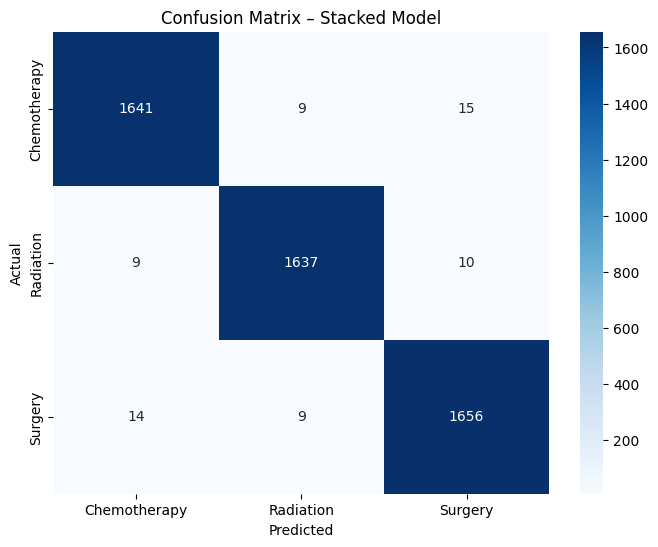

,Predicted_Treatment,Treatment_Confidence,Predicted_Survival_Months,Survival_Uncertainty
0,Radiation,0.624624,30.508589,20.151823
1,Surgery,0.667417,51.020436,23.903645
2,Chemotherapy,0.817687,42.082582,19.401618
3,Surgery,0.859634,45.794910,22.045618
4,Radiation,0.775177,26.882313,16.311670
5,Chemotherapy,0.656070,46.703466,24.436381
6,Radiation,0.759719,52.757129,24.466531
7,Surgery,0.728534,43.686833,19.163685
8,Radiation,0.833013,24.491302,16.412721
9,Surgery,0.654637,43.606305,20.074099


In [ ]:
# IMPORTS
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.combine import SMOTEENN
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest

# DATA PREPROCESSING
df_proc = df.drop(columns=[
    'Patient_ID', 'Date_of_Diagnosis', 'Surgery_Status',
    'Radiation_Therapy', 'Chemotherapy', 'Country'
])

df_proc['Gender'] = df_proc['Gender'].map({'M':0, 'F':1, 'Other':2})
df_proc['Cancer_Type'] = df_proc['Cancer_Type'].astype('category').cat.codes
df_proc['Laterality'] = df_proc['Laterality'].map({'Left':0, 'Right':1, 'Bilateral':2})
df_proc['Stage_at_Diagnosis'] = df_proc['Stage_at_Diagnosis'].map({
    'Stage I':1, 'Stage II':2, 'Stage III':3, 'Stage IV':4
})
df_proc['Genetic_Markers'] = df_proc['Genetic_Markers'].fillna('None').map({'None':0, 'BRAF Mutation':1})
df_proc['Family_History'] = df_proc['Family_History'].astype(int)

# Feature engineering
df_proc['Stage_Genetic'] = df_proc['Stage_at_Diagnosis'] * df_proc['Genetic_Markers']
df_proc['Type_Stage'] = df_proc['Cancer_Type'] * df_proc['Stage_at_Diagnosis']
df_proc['Family_Genetic'] = df_proc['Family_History'] * df_proc['Genetic_Markers']

# Encode target
le = LabelEncoder()
df_proc['Treatment_Label'] = le.fit_transform(df_proc['Treatment_Type'])

X = df_proc.drop(columns=['Treatment_Type', 'Treatment_Label', 'Survival_Time_Months', 'Outcome_Status'])
y = df_proc['Treatment_Label'].values
class_names = le.classes_
num_classes = len(class_names)


# MODEL DECLARATION HELPER FUNCTIONS
def create_base_models():
    rf_clf = RandomForestClassifier(
        n_estimators=1800, max_depth=None, min_samples_split=4,
        min_samples_leaf=2, max_features="sqrt",
        class_weight="balanced_subsample", n_jobs=-1, random_state=42
    )
    cat_clf = CatBoostClassifier(
        verbose=0, random_state=42, iterations=1500,
        learning_rate=0.03, depth=7, l2_leaf_reg=5
    )
    mlp_clf = MLPClassifier(
        hidden_layer_sizes=(256,128), max_iter=800,
        activation='relu', solver='adam', random_state=42
    )
    return [rf_clf, cat_clf, mlp_clf]

def fix_probs(probs, y_train_fold, num_classes):
    """Ensure predict_proba output has consistent number of columns"""
    if probs.shape[1] != num_classes:
        fixed = np.zeros((probs.shape[0], num_classes))
        unique_classes = np.unique(y_train_fold)
        for i, cls in enumerate(unique_classes):
            fixed[:, cls] = probs[:, i]
        return fixed
    return probs


# STRATIFIED K-FOLD STACKING
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X.shape[0], num_classes * 3))  # 3 base models
meta_targets = y.copy()
confidence_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # SMOTEENN balancing
    smoteenn = SMOTEENN(random_state=42)
    X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)

    # Train base models
    fold_probs = []
    for model in create_base_models():
        model.fit(X_train_res, y_train_res)
        probs = model.predict_proba(X_val)
        probs = fix_probs(probs, y_train_res, num_classes)
        fold_probs.append(probs)

    # Concatenate predictions for meta-model
    fold_probs_concat = np.hstack(fold_probs)
    oof_preds[val_idx, :] = fold_probs_concat

    # Store fold-level confidence predictions
    fold_df = X_val.copy().reset_index(drop=True)
    fold_df['Actual_Label'] = le.inverse_transform(y_val)
    fold_df['Predicted_Probabilities'] = list(fold_probs_concat)
    confidence_results.append(fold_df)

# META-MODEL (XGBOOST)
meta_model = XGBClassifier(
    objective="multi:softprob", num_class=num_classes,
    n_estimators=1500, learning_rate=0.03, max_depth=6,
    reg_alpha=0.5, reg_lambda=2.0, eval_metric="mlogloss",
    use_label_encoder=False, random_state=42
)

meta_model.fit(oof_preds, meta_targets)

# Meta-model predictions
meta_probs = meta_model.predict_proba(oof_preds)
meta_preds = np.argmax(meta_probs, axis=1)
accuracy = accuracy_score(y, meta_preds)

print(f"\n===== True Stacking Accuracy ===== {accuracy:.4f}")
print(classification_report(y, meta_preds, target_names=class_names))

# Combine confidence-aware output
final_confidence_df = pd.concat(confidence_results, ignore_index=True)


# CONFUSION MATRIX
cm = confusion_matrix(meta_targets, meta_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – Stacked Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SURVIVAL ANALYSIS

# Confidence scores
confidence_scores = np.max(meta_probs, axis=1)

# Prepare survival dataset
df_surv = df.copy()
df_surv['Outcome_Event'] = df_surv['Outcome_Status'].map({
    'Deceased': 1, 'In Remission': 0, 'Active': 0
})

X_surv = X.copy()
y_surv = Surv.from_arrays(
    event=df_surv['Outcome_Event'].astype(bool),
    time=df_surv['Survival_Time_Months']
)

X_train_surv, X_test_surv, y_train_surv, y_test_surv = train_test_split(
    X_surv, y_surv, test_size=0.2, random_state=42
)

rsf = RandomSurvivalForest(
    n_estimators=200, min_samples_split=10, min_samples_leaf=15,
    max_features="sqrt", n_jobs=-1, random_state=42
)

rsf.fit(X_train_surv, y_train_surv)
y_pred_surv = rsf.predict(X_test_surv)

# Uncertainty estimation
all_tree_preds = np.array([tree.predict(X_test_surv) for tree in rsf.estimators_])
pred_std = np.std(all_tree_preds, axis=0)

# PERSONALIZED PROGNOSIS TABLE
surv_test_idx = X_test_surv.index

personalized_results = pd.DataFrame({
    "Predicted_Treatment": le.inverse_transform(meta_preds[surv_test_idx]),
    "Treatment_Confidence": confidence_scores[surv_test_idx],
    "Predicted_Survival_Months": y_pred_surv,
    "Survival_Uncertainty": pred_std
})

personalized_results.head(10)



--- SHAP Summary for RandomForest ---


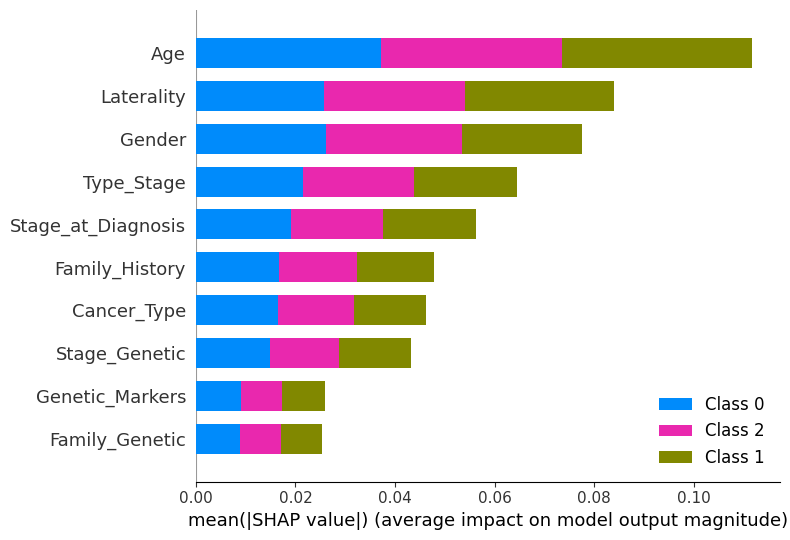


--- SHAP Summary for CatBoost ---


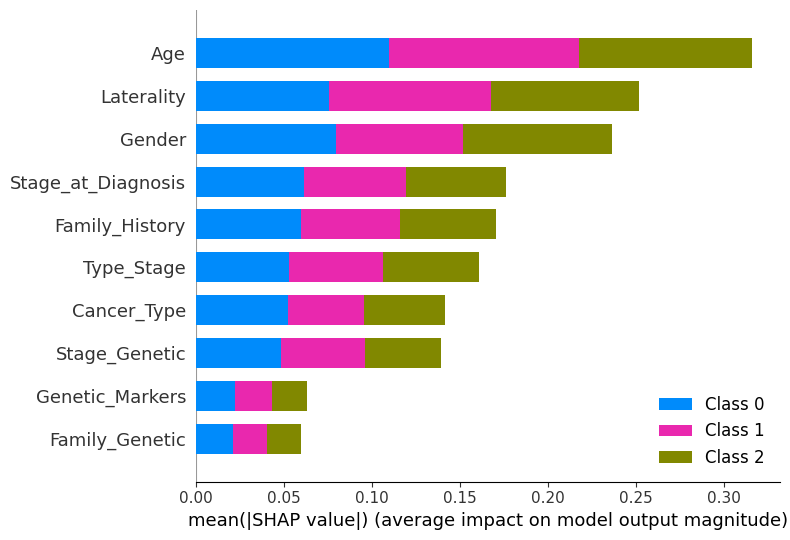


--- SHAP Summary for MLP ---


  0%|          | 0/1000 [00:00<?, ?it/s]

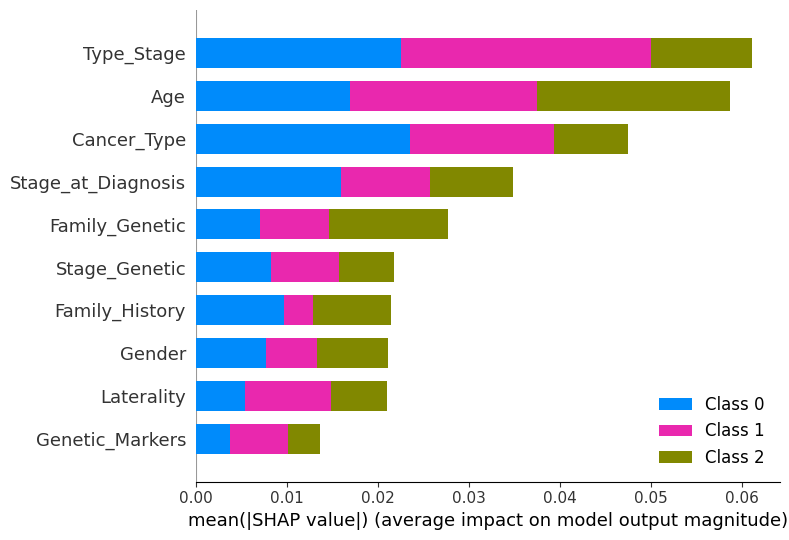

In [ ]:
# ===============================
# 8️⃣ SHAP EXPLAINABILITY FOR BASE MODELS
# ===============================
import shap

# Recreate base models and fit on full dataset
rf_clf, cat_clf, mlp_clf = create_base_models()
rf_clf.fit(X, y)
cat_clf.fit(X, y)
mlp_clf.fit(X, y)

base_models = [rf_clf, cat_clf, mlp_clf]
model_names = ["RandomForest", "CatBoost", "MLP"]

for model, name in zip(base_models, model_names):
    print(f"\n--- SHAP Summary for {name} ---")

    # Use TreeExplainer for tree-based models, KernelExplainer for MLP
    if name in ["RandomForest", "CatBoost"]:
        explainer = shap.TreeExplainer(model)
    else:
        # For MLP use KernelExplainer (slower)
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X, 50))

    shap_values = explainer.shap_values(X_test_surv)

    # summary_plot for feature importance
    shap.summary_plot(
        shap_values,
        features=X_test_surv,
        feature_names=X_test_surv.columns.tolist(),
        plot_type="bar",
        show=True
    )
